In [5]:
# Standard library imports
import subprocess
import os
from pathlib import Path

from multiview_mapping_toolkit.utils.visualization import show_segmentation_labels

# Set constants
You should be able to define most of the behavior from these constants

In [6]:
test_site = "delta"
training_sites = ["chips", "valley"]

In [7]:
## Python interpreter and script locations
MMSEG_UTILS_PYTHON = "/ofo-share/repos-david/conda/envs/mmseg-utils/bin/python"
MMSEG_PYTHON = "/ofo-share/repos-david/conda/envs/openmmlab/bin/python"

VIS_PREDS_SCRIPT = "/ofo-share/repos-david/mmsegmentation_utils/dev/visualization/visualize_semantic_labels.py"
INFERENCE_SCRIPT = "/ofo-share/repos-david/mmsegmentation/tools/inference.py"

# One folder up from scripts
PROJECT_ROOT = Path(os.path.abspath(""), "..", "..", "..").resolve()

TRAINING_SITES_STR = "_".join(training_sites)
TRAINING_DATA_FOLDER = Path(
    PROJECT_ROOT,
    "models",
    "multi_site",
    TRAINING_SITES_STR,
)
WORK_DIR = Path(TRAINING_DATA_FOLDER, "work_dir")

INFERENCE_IMAGE_FOLDER = Path(
    PROJECT_ROOT,
    "per_site_processing",
    test_site,
    "03_training_data",
    "images_near_labels",
)
PREDICTIONS_FOLDER = Path(
    PROJECT_ROOT,
    "per_site_processing",
    test_site,
    "04_model_preds",
    f"{TRAINING_SITES_STR}_MVMT_model",
)

# Generate predictions with the model

In [8]:
config_file = list(Path(WORK_DIR).glob("*py"))[0]
checkpoint_file = Path(WORK_DIR, "iter_10000.pth")
BATCH_SIZE = 2

subprocess.run(
    f"{MMSEG_PYTHON} {INFERENCE_SCRIPT} {config_file} {checkpoint_file} {INFERENCE_IMAGE_FOLDER} {PREDICTIONS_FOLDER} --batch-size {BATCH_SIZE}",
    shell=True,
)

/ofo-share/repos-david/mmsegmentation/mmseg/models/builder.py:42: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn(
/ofo-share/repos-david/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:245: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/chips_valley/work_dir/iter_10000.pth


CompletedProcess(args='/ofo-share/repos-david/conda/envs/openmmlab/bin/python /ofo-share/repos-david/mmsegmentation/tools/inference.py /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/chips_valley/work_dir/chips_valley.py /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/chips_valley/work_dir/iter_10000.pth /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/delta/03_training_data/images_near_labels /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/delta/04_model_preds/chips_valley_MVMT_model --batch-size 2', returncode=0)

# Visualize predictions

In [9]:
# Add _vis to the folder name. Can't just add _vis to the str representation because it might have a trailing slash
pred_vis_dir = Path(
    Path(PREDICTIONS_FOLDER).parent, Path(PREDICTIONS_FOLDER).parts[-1] + "_vis"
)
STRIDE = 10

subprocess.run(
    f"{MMSEG_UTILS_PYTHON} {VIS_PREDS_SCRIPT} --image-dir {INFERENCE_IMAGE_FOLDER} "
    + f"--seg-dir {PREDICTIONS_FOLDER} --output-dir {pred_vis_dir} --stride {STRIDE}",
    shell=True,
)

visualizing to /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/delta/04_model_preds/chips_valley_MVMT_model_vis: 100%|██████████| 118/118 [07:00<00:00,  3.56s/it]


CompletedProcess(args='/ofo-share/repos-david/conda/envs/mmseg-utils/bin/python /ofo-share/repos-david/mmsegmentation_utils/dev/visualization/visualize_semantic_labels.py --image-dir /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/delta/03_training_data/images_near_labels --seg-dir /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/delta/04_model_preds/chips_valley_MVMT_model --output-dir /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/delta/04_model_preds/chips_valley_MVMT_model_vis --stride 10', returncode=0)

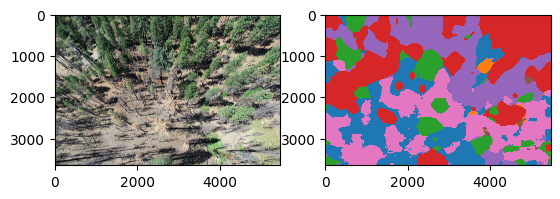

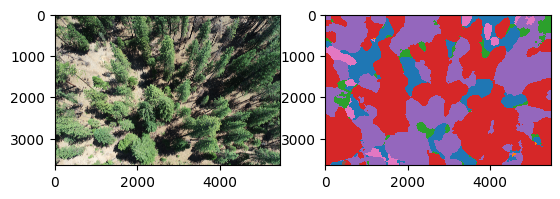

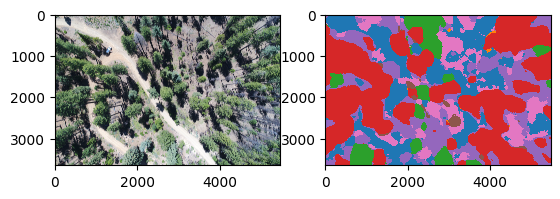

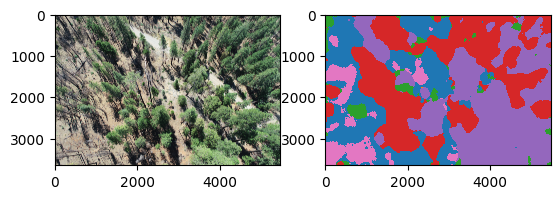

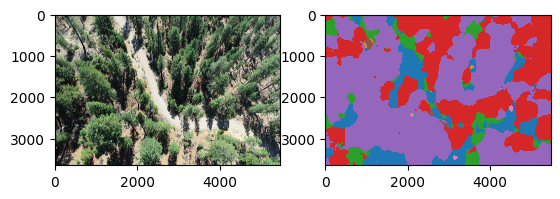

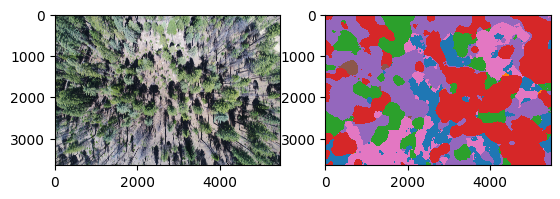

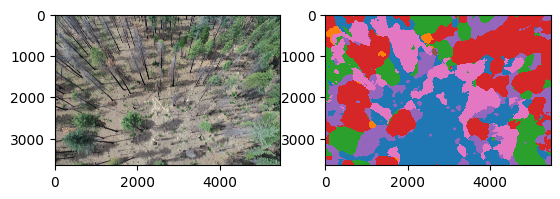

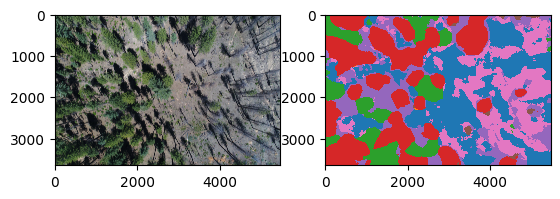

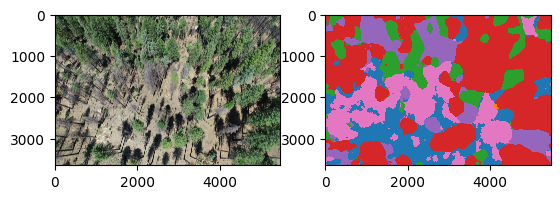

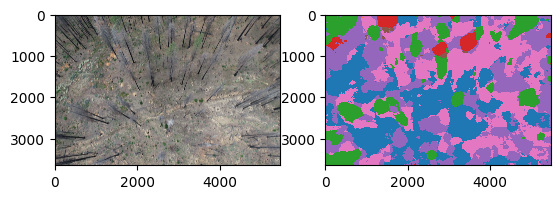

In [10]:
show_segmentation_labels(label_folder=PREDICTIONS_FOLDER, image_folder=INFERENCE_IMAGE_FOLDER)